# Normalized Inter-Class Variance (NICV) Analysis

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.insert(0, '../src/utils')
from trace_handler import TraceHandler
from nicv import nicv
import constants

## Preprocessing

### Get Data

In [2]:
paths = {'D1_K1': '/prj/side_channel/PinataTraces/CURR/D1-K1_50k_500MHz + Resampled at 168MHz.trs',
         'D1_K1_extra': '/prj/side_channel/PinataTraces/CURR/D1-K1_50k_500MHz (NICV) + Resampled at 168MHz.trs',
         'D1_K2': '/prj/side_channel/PinataTraces/CURR/D1-K2_50k_500MHz + Resampled at 168MHz.trs',
         'D1_K3': '/prj/side_channel/PinataTraces/CURR/D1-K3_50k_500MHz + Resampled at 168MHz.trs',
         'D2_K1': '/prj/side_channel/PinataTraces/CURR/D2-K1_50k_500MHz + Resampled at 168MHz.trs',
         'D2_K2': '/prj/side_channel/PinataTraces/CURR/D2-K2_50k_500MHz + Resampled at 168MHz.trs', 
         'D2_K3': '/prj/side_channel/PinataTraces/CURR/D2-K3_50k_500MHz + Resampled at 168MHz.trs'}

trace_handlers = {key: TraceHandler(path) for key, path in paths.items()}

Labeling traces: 100%|██████████| 50000/50000 [00:21<00:00, 2305.92it/s]


### Define all NICV experiments

In [3]:
# Same Device, Same Key at different times
nicv_same_config = ['D1_K1', 'D1_K1_extra']
same_config_cmap = plt.cm.Set1

# Same Device, Different Key
nicv_same_device = {d: [f'{d}_{k}' for k in constants.KEYS] for d in constants.DEVICES}
same_device_cmap = plt.cm.Dark2

# Different Device, Same Key
nicv_same_key = {k: [f'{d}_{k}' for d in constants.DEVICES] for k in constants.KEYS}
same_key_cmap = plt.cm.tab10

# All possible Device-Key configurations
nicv_all_config = [f'{d}_{k}' for d in constants.DEVICES for k in constants.KEYS]
all_config_cmap = plt.cm.Set1

### Define a Plot Fuction

In [4]:
def plot_nicv_all_bytes(trace_handlers, cmap):
    
    """
    Compute and plot NICV values for each byte.
    
    Parameters:
        - trace_handlers (TraceHandler dict): 
            set of TraceHandlers containing the data to use to 
            compute the NICV.
        - cmap (matplotlib.colors.ListedColormap):
            color palette to use in the plots.
    
    Returns:
        Figure object containing all plots.
    """
    
    colors = cmap(range(len(trace_handlers)))
    
    f, ax = plt.subplots(4, 4, figsize=(25,25))
    row = 0

    for b in tqdm(range(16)):
    
        col = b % 4
    
        ax[row, col].set_prop_cycle('color', colors)
    
        for key, trace_handler in trace_handlers.items():
        
            traces = trace_handler.get_traces()
            plaintexts = trace_handler.get_plaintexts()
        
            nicv_val = nicv(traces, plaintexts, b)
        
            ax[row, col].plot(nicv_val, label=key)
            ax[row, col].legend()
            ax[row, col].set_title(f'Byte {b}')
            ax[row, col].set_xlabel('Samples')
            ax[row, col].set_ylabel('NICV')
    
        if col == 3:
            row += 1

    plt.show()
    
    return f

## NICV - Same Device-Key configuration at two different times 

100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


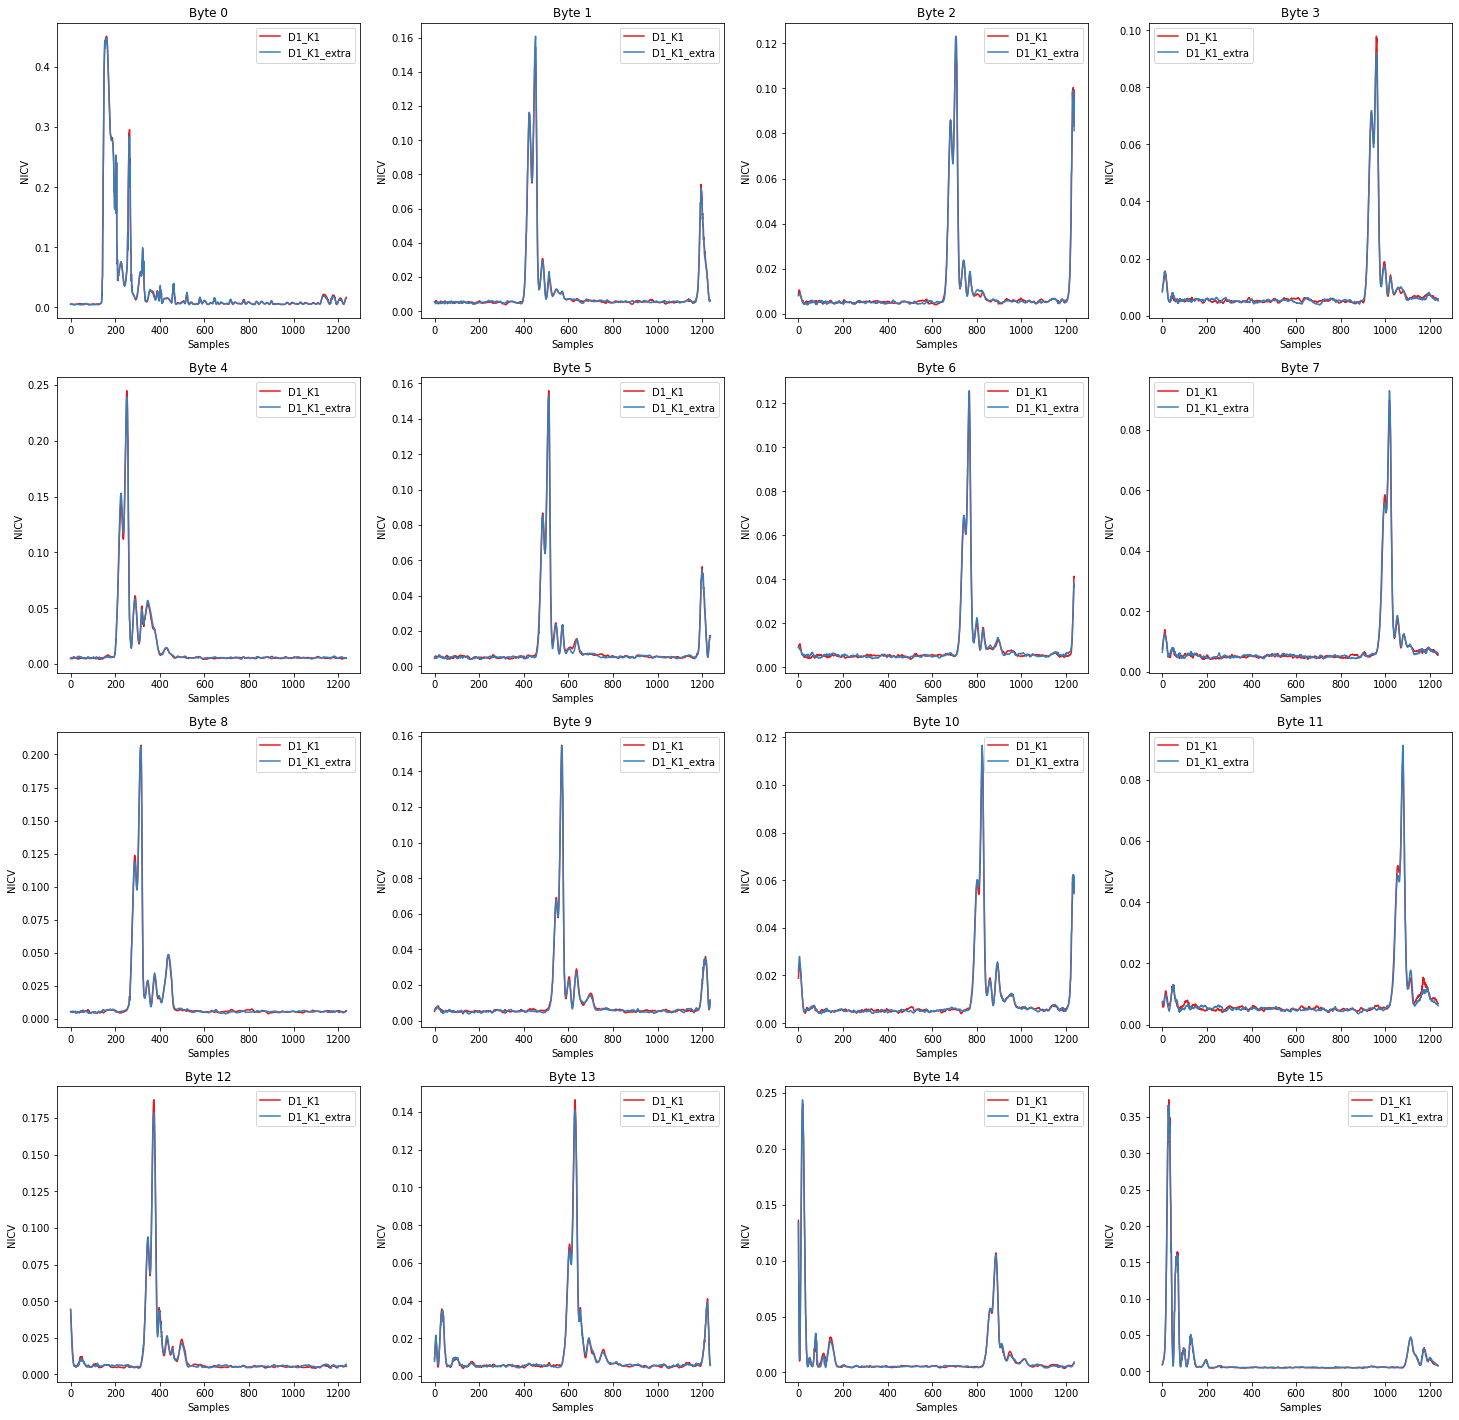

In [5]:
exp_trace_handlers = {config: trace_handlers[config] for config in nicv_same_config}

figure = plot_nicv_all_bytes(exp_trace_handlers, same_config_cmap)

This result shows how the leakages are basically the same if only one Device-Key configuration is used.

This conclusion is true for each key-byte.

### Save the figure as PNG

In [6]:
figure.savefig('../../MDM32/notebooks/images/NICV_same_config.png', bbox_inches='tight', dpi=600)

## NICV - Same Device, Different Key

100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


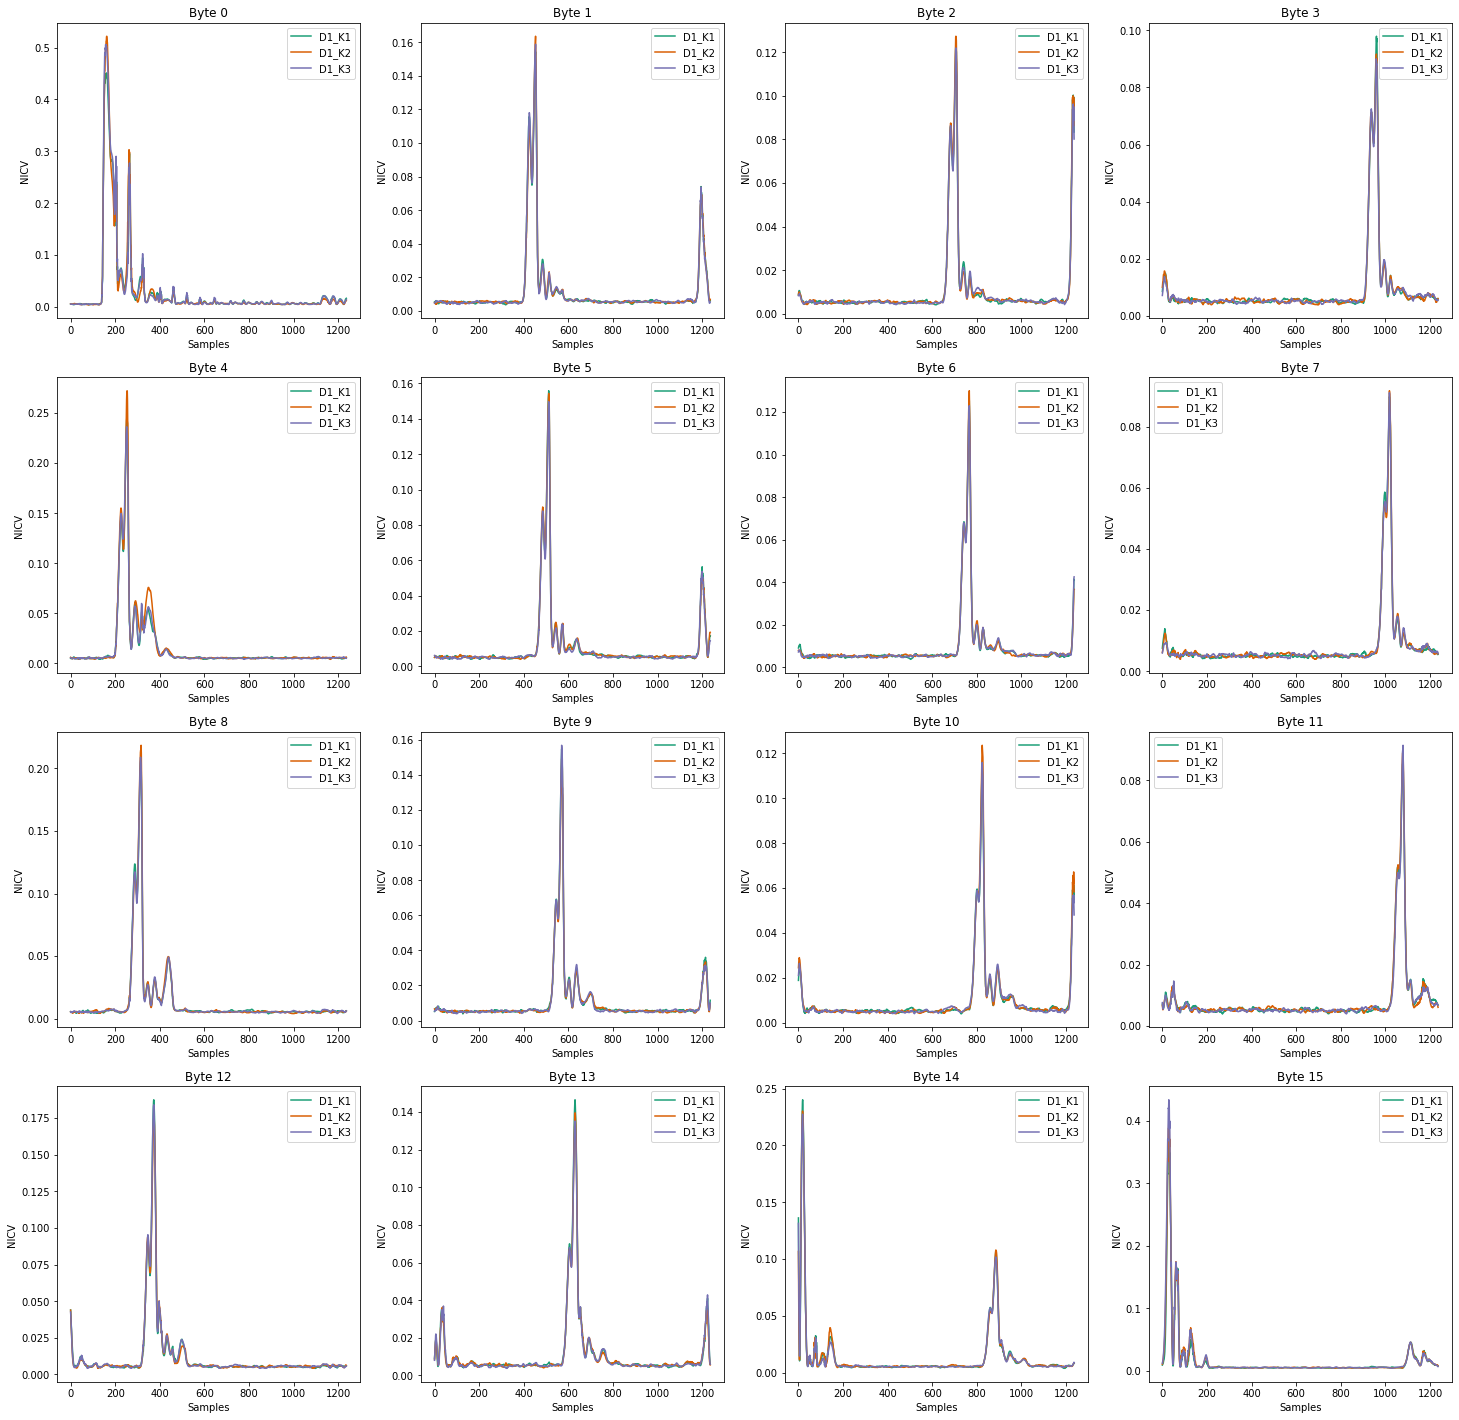

100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


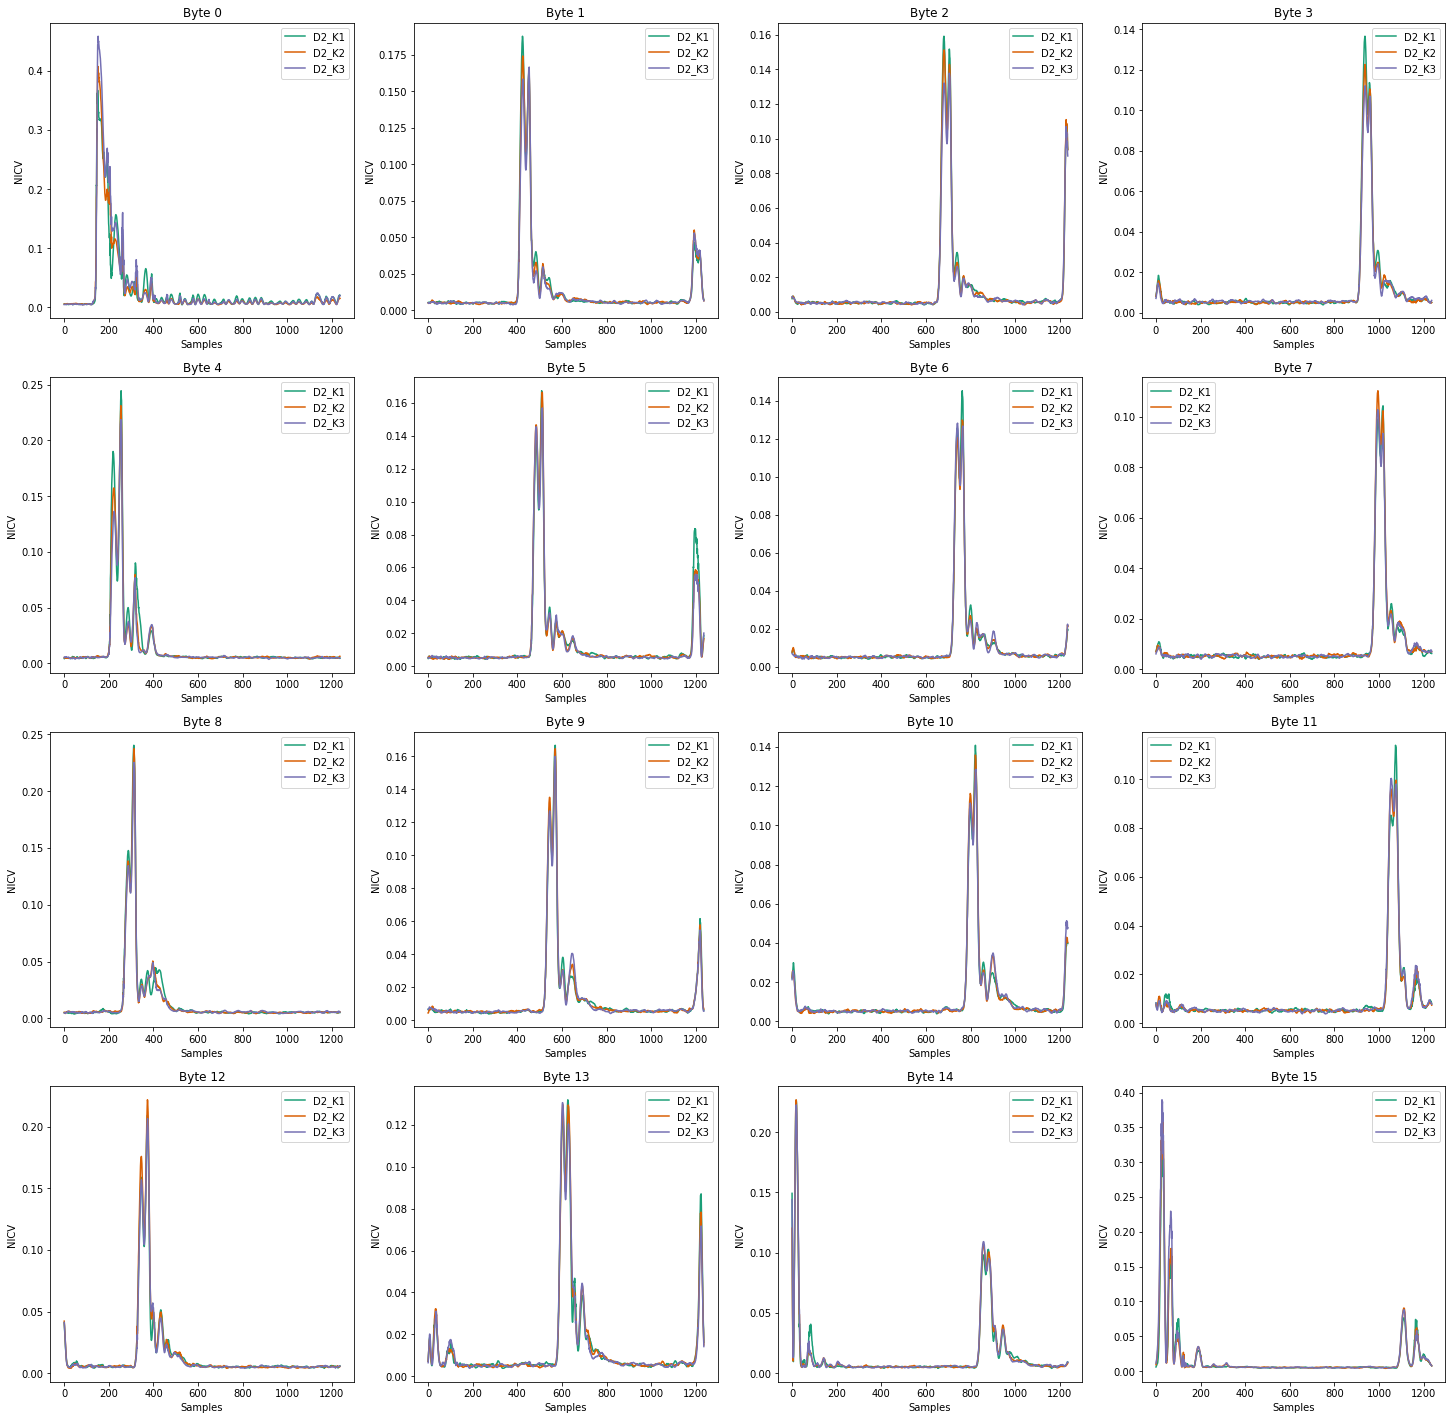

In [7]:
figures = {}

for d, config in nicv_same_device.items():
    exp_trace_handlers = {c: trace_handlers[c] for c in config}
    figure = plot_nicv_all_bytes(exp_trace_handlers, same_device_cmap)
    figures[d] = figure

The plots highlight that there is no substantial difference in leakage considering configurations with the same device, but with different keys.

Small differences can be seen for example in D1-Byte4 and D2-Byte1, but they refer to different values of NICV, not to different behaviors of the plots (all plots have the same trend).

In conclusion, there is no relevant difference in leakage-behavior if only the encryption key is changed. 

In [8]:
for d, figure in figures.items():
    figure.savefig(f'../../MDM32/notebooks/images/NICV_same_device_{d}.png', bbox_inches='tight', dpi=600)

## NICV - Different Device, Same Key

100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


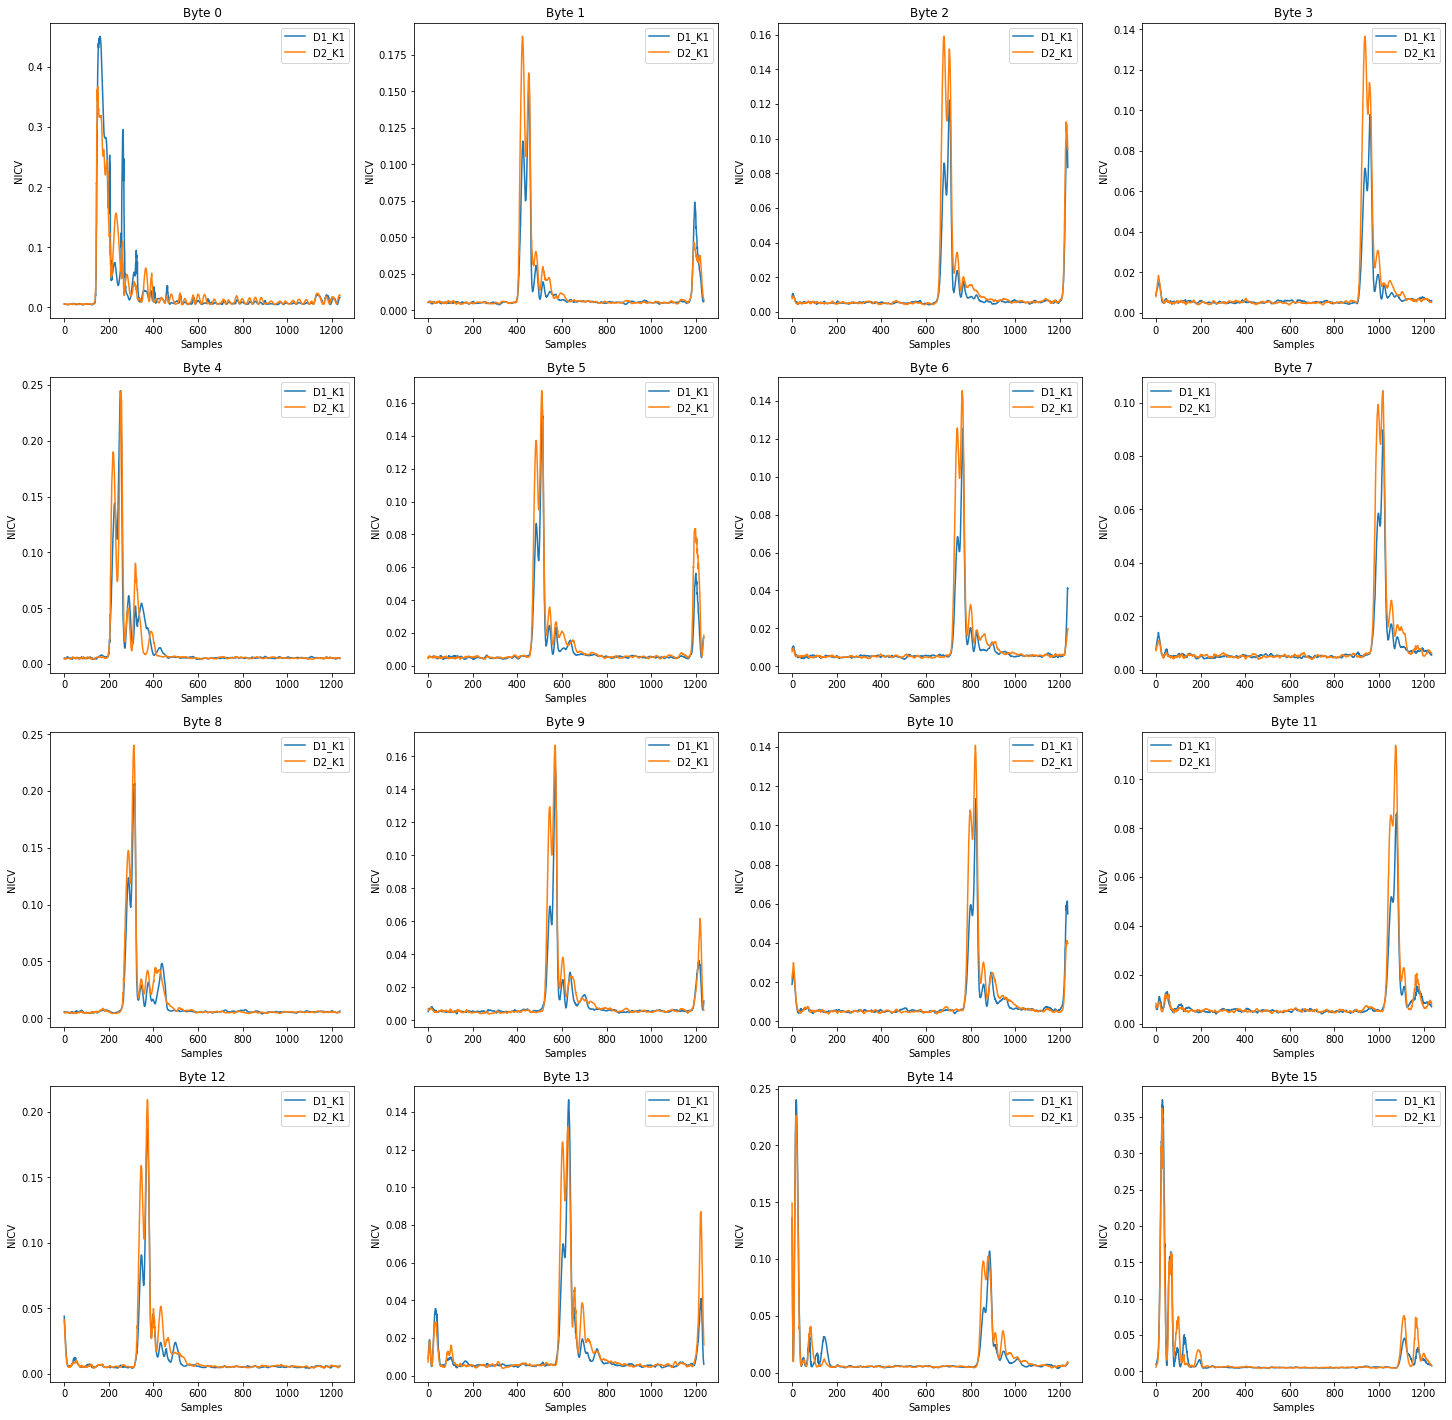

100%|██████████| 16/16 [00:06<00:00,  2.30it/s]


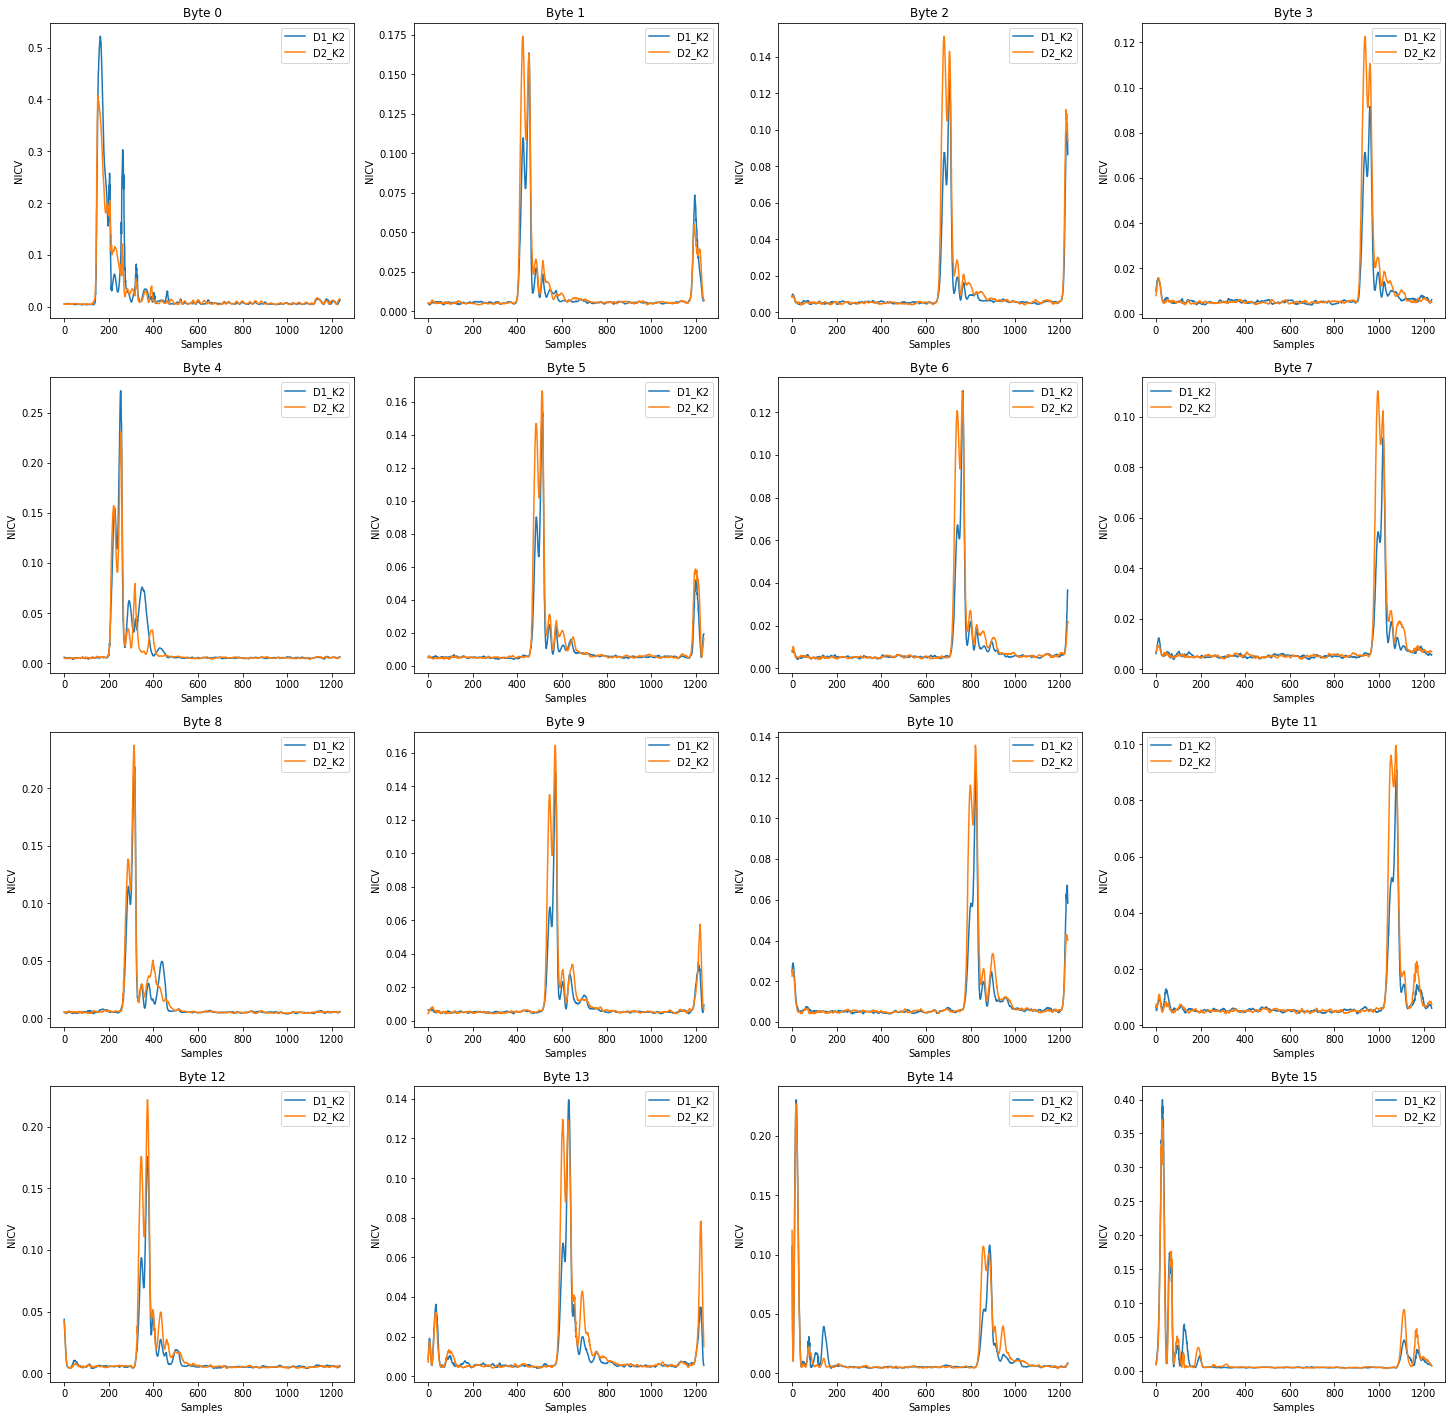

100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


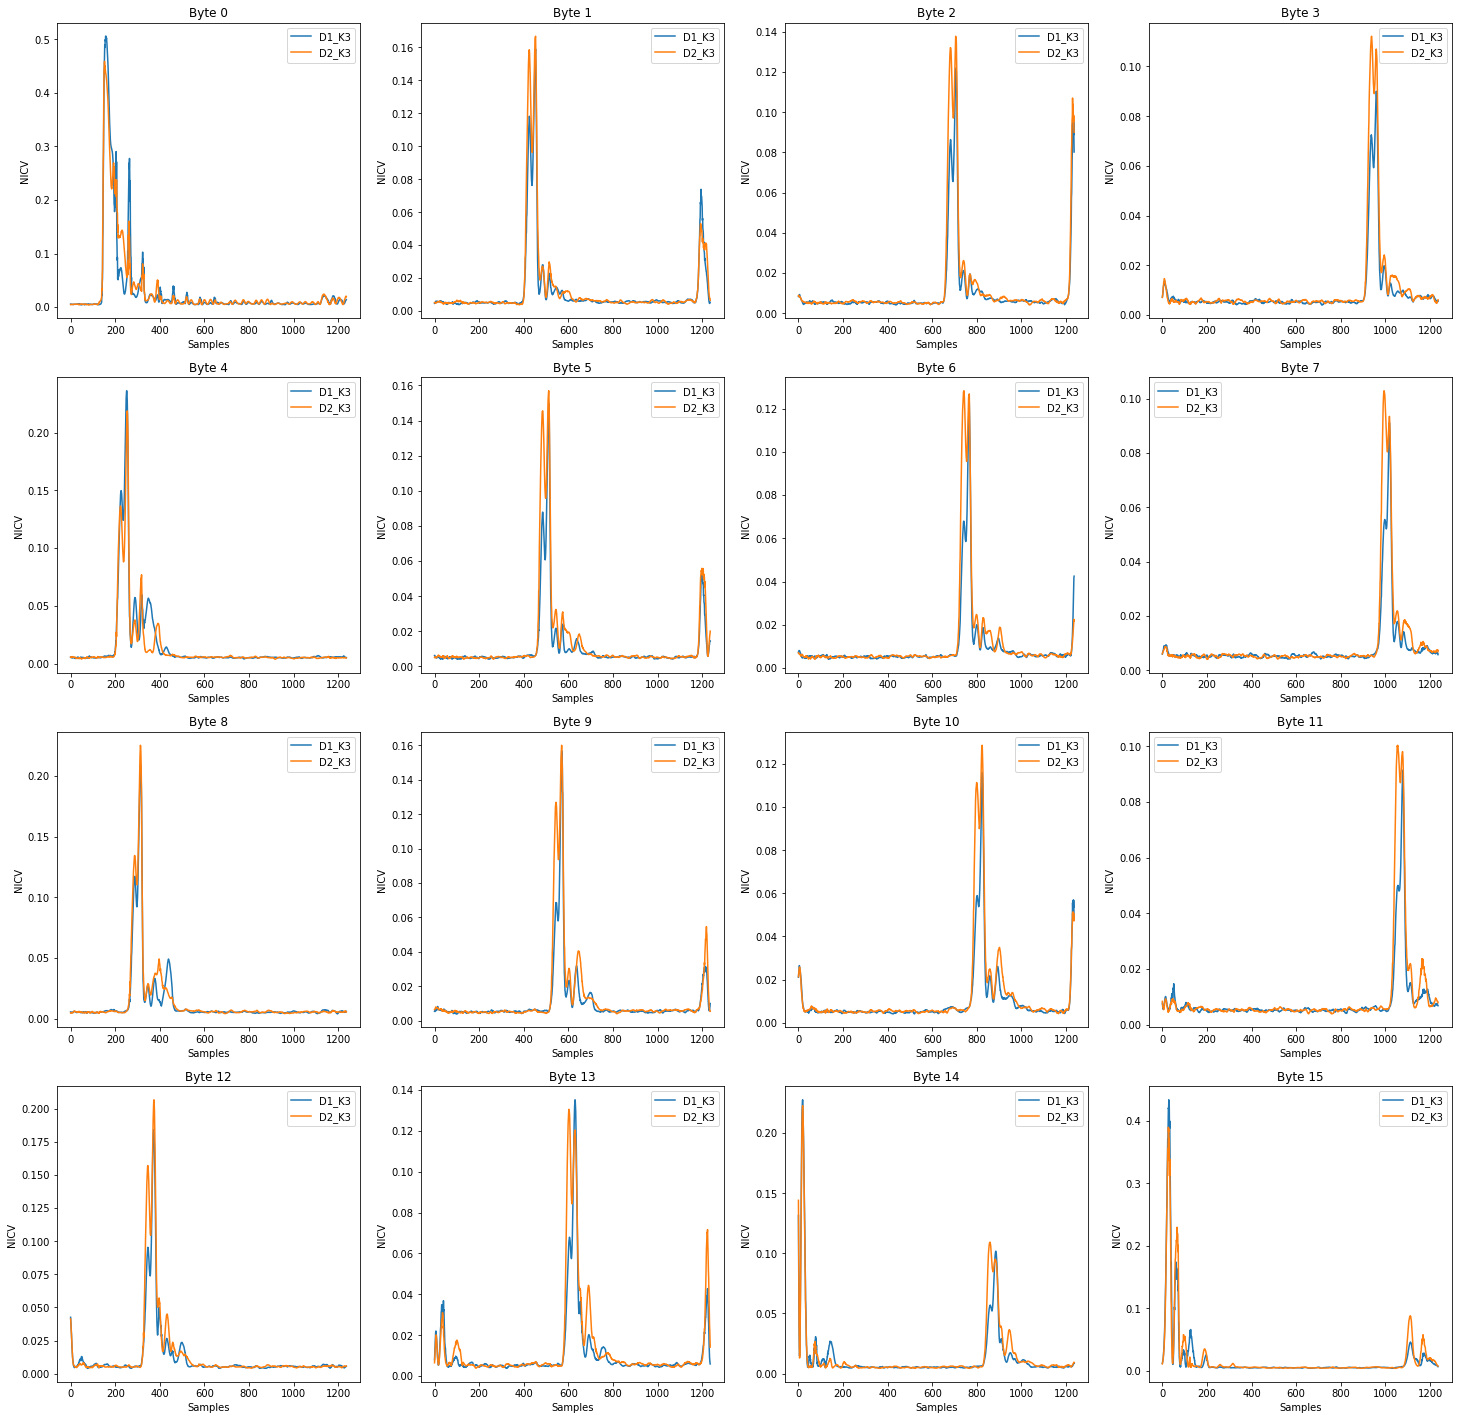

In [9]:
figures = {}

for k, config in nicv_same_key.items():
    exp_trace_handlers = {c: trace_handlers[c] for c in config}
    figure = plot_nicv_all_bytes(exp_trace_handlers, same_key_cmap)
    figures[k] = figure

This result shows how it is possible to add diversity in leakage considering different devices.

Indeed, from the plots it is visible that different devices sometimes produce different leakages: not only there are some differences in leakage intensity (heights of the peaks), but also (and more importantly) there are apparent opposite behaviors in specific points.

The overall shape of the plots is however very similar, as expected, being the devices produced by the same manufacturer.

Examples of opposite behavious are K1-Byte3, where both D1 and D2 have two main peaks, but D1's right peak is higher than the left one, while for D2 the opposite is verified, and K1-Byte4, where near sample 400 there is a peak for D1, while there is a sort of "valley" for D2. 

In [10]:
for k, figure in figures.items():
    figure.savefig(f'../../MDM32/notebooks/images/NICV_same_key_{k}.png', bbox_inches='tight', dpi=600)

## NICV - All different Device-Key configurations

100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


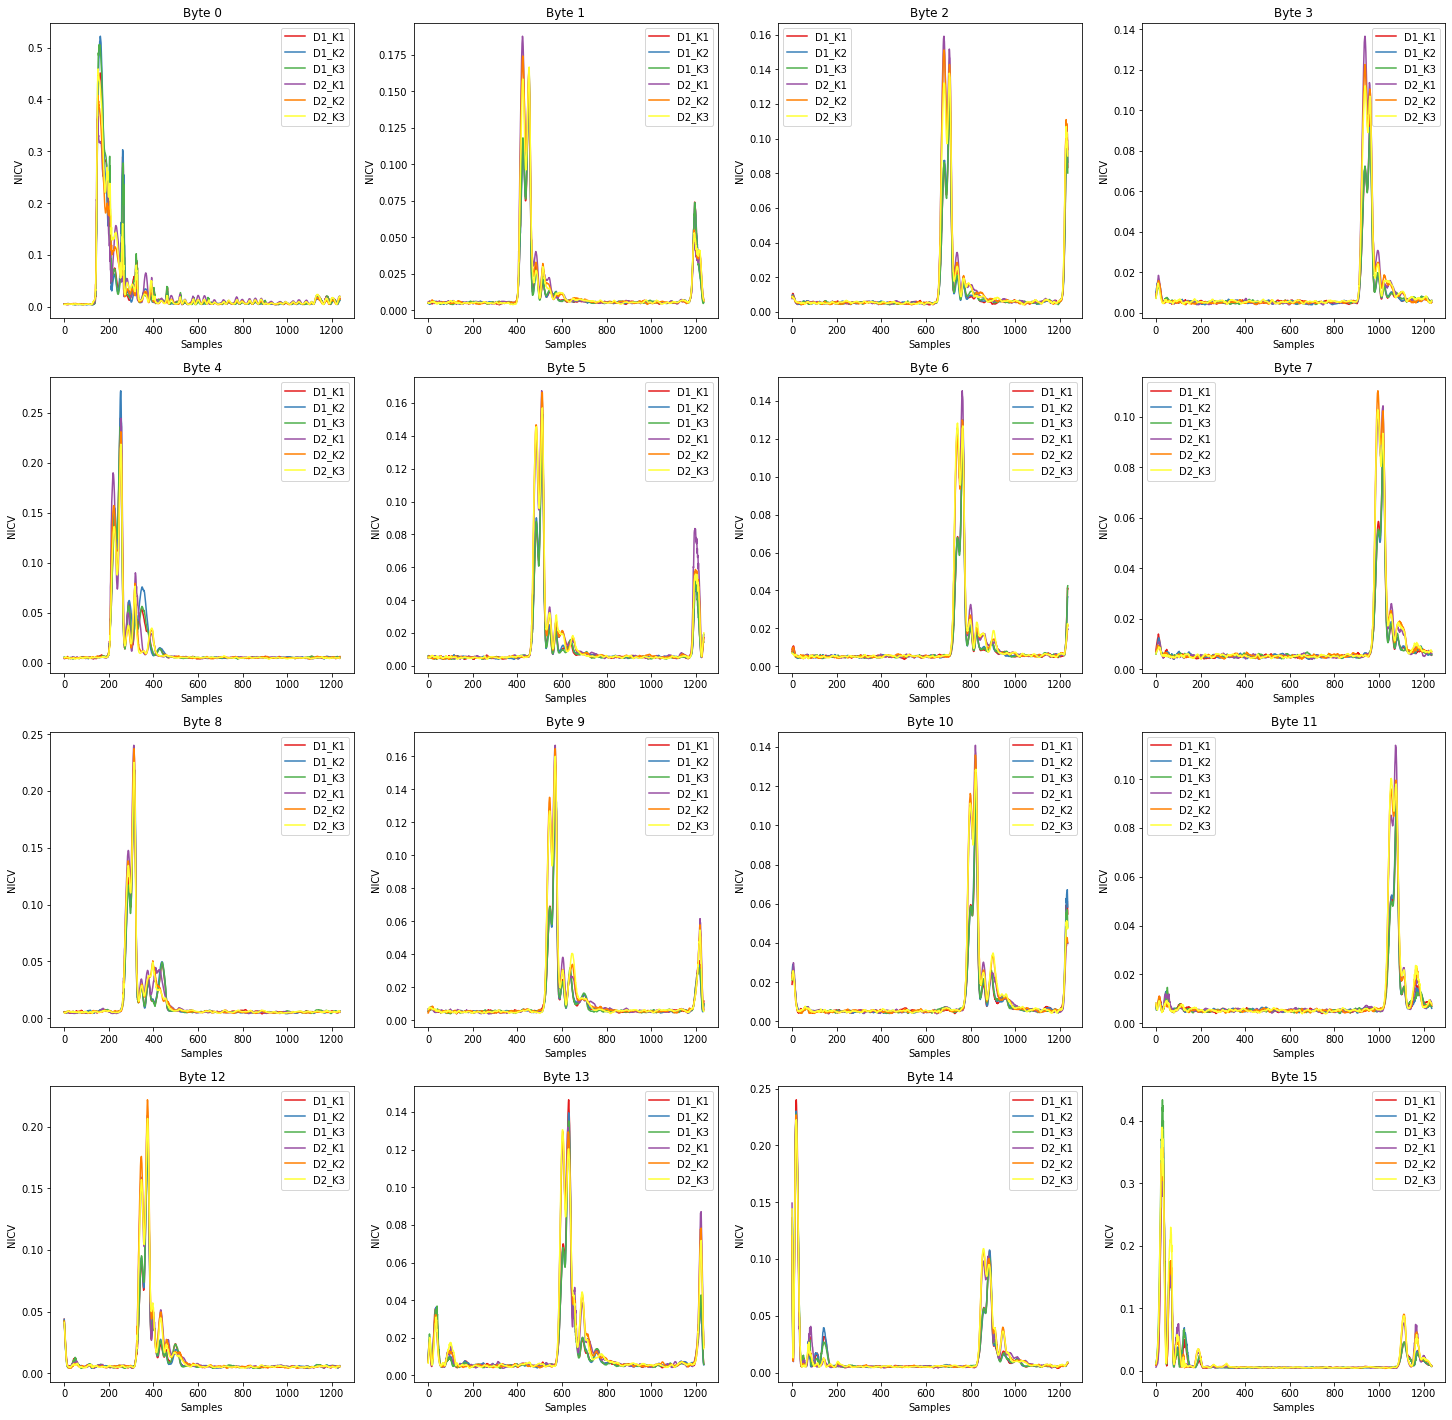

In [11]:
exp_trace_handlers = {config: trace_handlers[config] for config in nicv_all_config}

figure = plot_nicv_all_bytes(exp_trace_handlers, all_config_cmap)

These plots are a summary of alle the previous ones, and prove that it is possible to add diversity in leakage considering different devices and different keys, as can be seen from the (small) differences in leakage intensity and trend.

### Save the figure as PNG

In [12]:
figure.savefig('../../MDM32/notebooks/images/NICV_all_config.png', bbox_inches='tight', dpi=600)